# Introduction to MindSphere Analytics APIs - TrendPrediction

This demo will use the mindconnect-nodejs CLI to call the mindsphere APIs. 
The information about the installation and usage of CLI:

https://opensource.mindsphere.io/docs/mindconnect-nodejs/cli/index.html


You will need to get and configure the service credentials to use this notebook. 
Here is a description how to acquire and setup the service credentials:

https://opensource.mindsphere.io/docs/mindconnect-nodejs/li/setting-up-the-cli.html


## Setup the mindconnect-nodejs CLI

please change the line below to the passkey you were using when setting up the service credentials

In [59]:
passkey = "passkey.4.unit.test"

## Setup the jupyter notebook

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize'] = [8, 8]

## Industrial Pump - TimeSeries Data

We will use the downloaded industrial pump data from mindsphere to try to fit the model which can predict flow problems. 
The mindsphere demo application is available at

https://dreamforce.mindconnect.rocks

This application can be used without mindsphere credentials. 
* username: guest@mindsphere.io
* password: Siemens123!

Following data was recorded over the time:

- **Flow** - Water flow through the pump
- **MotorCurrent** Motor Current
- **PressureIn** Inlet pressure
- **PressureOut** Outlet pressure
- **StuffingBoxTemperature** The temperature of the pump

![pumpschema](https://dreamforce.mindconnect.rocks/assets/img/Pump-Station-Scheme.jpg)

The historic data was downloaded from MindSphere and  is available in the **data** directory of this notebook.


## First look at the data

The first file already has a typical behavior of the malfunctioning pump. The stuffing box temperature is increased and the flow is dropping.

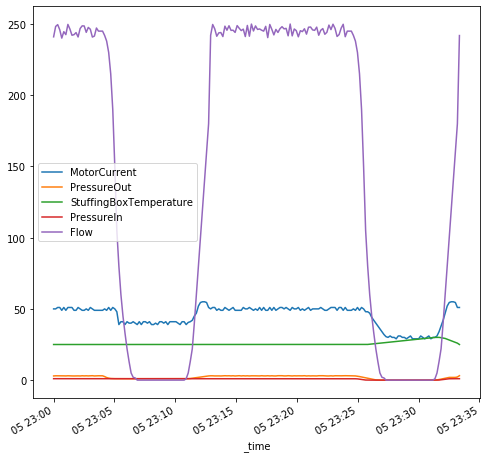

In [61]:
data = pd.read_json("./data/PUMP-011/PumpData/PumpData_0.json")
data.plot(x="_time")

## Training the models

We will use this data to train several polynomial regression models. Essentially we are trying to find a good fit for the 

**flow = f (MotorCurrent,PressureOut,StuffingBoxTemperature,PressureIn)** function

and we will try several polynomial functions (from linear to 4th-degree polynomial)

The code below will use the CLI to call MindSphere trend-prediction API. We are using the content of the first file as the input and are creating 4 models using the CLI.

See also : https://developer.mindsphere.io/apis/analytics-trendprediction/api-trendprediction-basics.html


In [62]:
models = []
for degree in range(1,5):
    id = !mc trend-prediction \
        --mode train \
        --file "./data/PUMP-011/PumpData/PumpData_0.json" \
        --input "MotorCurrent,PressureOut,StuffingBoxTemperature,PressureIn" --output "Flow" \
        --degree $degree \
        --passkey $passkey
    
    modelid = str(id).split(' ')[4]
    models.append(modelid)


models


['5581ee88-4bbf-4832-b6de-d44bbb25c7fb',
 '6e36d1af-bbc1-448d-bdbd-b99b808c663f',
 'a1ded879-89ad-45d5-b33f-3064dd264b08',
 '7239276b-a97f-4e48-95b9-216e94b75400']

## Predicting the flow using trained models

The function below is using the CLI in the --predict mode to calculate the predictions with all models. We are passing the **modelid** parameter from the list above in order to use that trained model to invoke the prediction.

In [63]:
def predictWith (models, filename):
    results = []

    for modelid in models:
        predictionList = !mc trend-prediction --mode predict --modelid $modelid \
        --input "MotorCurrent,PressureOut,StuffingBoxTemperature,PressureIn" --output "Flow" \
        --predictfile $filename --passkey $passkey

        result = ''.join(str(e) for e in predictionList)
        df = pd.read_json(result);
        prediction = pd.DataFrame.from_dict(df["timeSeries"][0])
        prediction["_time"] = pd.to_datetime(prediction["_time"])
        results.append(prediction)
    
    return results
    

## Testing the models

Now is the time to test the trained models. We will apply each model to the json data stored in the **PumpData_\*.json** 
files and calculate the cumulative error of the prediction. The produced images show the discrepancies between the actual value and our prediction. The curves are close to each other but it is already obvious that some curves are closer to the prediction than the others.

* Flow - Measured Flow (actual measured values)
* Flow_1 - Linear regression model
* Flow_2 - Quadratic regression model
* Flow_3 - Cubic regression model
* Flow_4 - Quartic (4th-degree polynomial) regression model

We will also calculate the cumulative error (the distance of the prediction to the actual value) and pick the model with the smallest cumulative error.

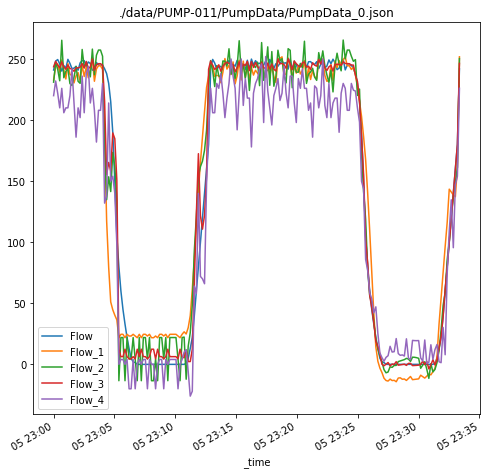

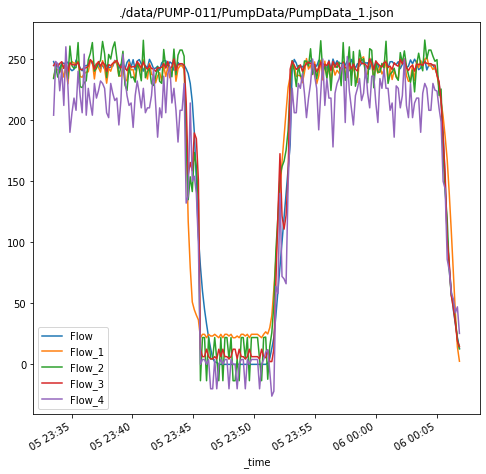

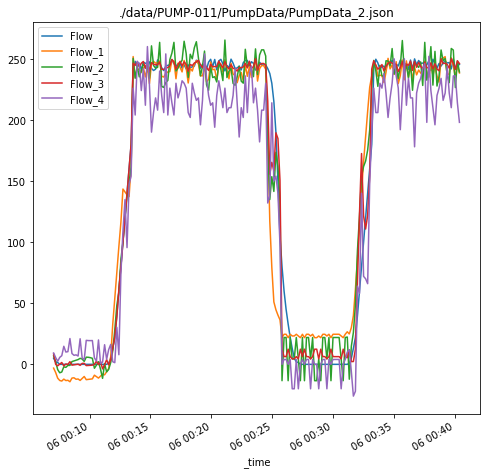

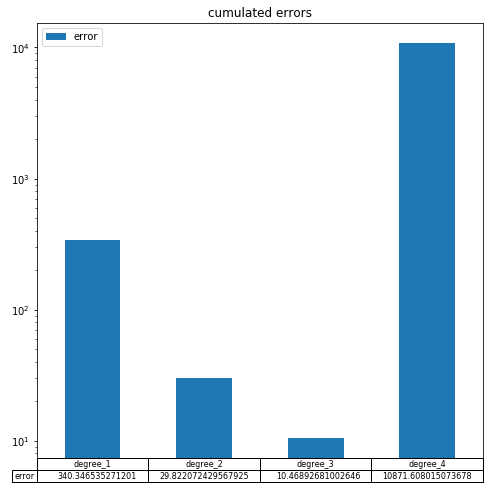

In [64]:
errors = {"degree_1": 0, "degree_2": 0, "degree_3": 0, "degree_4": 0}

filenames = [
    './data/PUMP-011/PumpData/PumpData_0.json',
    './data/PUMP-011/PumpData/PumpData_1.json',
    './data/PUMP-011/PumpData/PumpData_2.json']

# This uses all files for training but takes a lot of time...
# import glob
# filenames = enumerate(glob.glob('./data/PUMP-011/PumpData/PumpData_*.json'))

for fileindex, filename in enumerate(filenames):
    original = pd.read_json(filename)
    graphdata = original[['_time','Flow']]
    results = predictWith(models, filename)
    
    for idx, prediction in enumerate(results):
        graphdata = pd.merge(graphdata, prediction, on="_time", suffixes=("", "_" + str(idx+1) ));
        error = abs(sum(graphdata["Flow"]) - sum(graphdata["Flow_"+str(idx+1)]))
        errors["degree_" + str(idx+1)] += error
    
    if fileindex < 3:
        graphdata.plot(x="_time", title=filename); 
        
        
errors = pd.DataFrame.from_dict(errors, orient='index', columns=["error"])
errors.plot(kind="bar", title="cumulated errors", logy=True, table=True, xticks=[])


## Finding the best model

The best model is the one with smallest cumulative error, in our case 
it is the cubic model which predicts the outcome with the smallest error.

The model can be saved and executed also without mindsphere for example on the industrial edge.


In [66]:
bestmodelid = models[int(str(errors.idxmin().values[0]).split("_")[1])] # The best model is the one with smallest error
model = !mc trend-prediction --mode get --modelid $bestmodelid --passkey $passkey

import json
from IPython.display import JSON
print (model.pop()) # remove the CLI message at the end 
modeljson = ''.join (str(e) for e in model);
# fancy print the model
JSON(json.loads(modeljson), expanded=True)

Sucessfully retrieved model with 7239276b-a97f-4e48-95b9-216e94b75400 id.


<IPython.core.display.JSON object>

## Cleaning up

The ```mc trend-prediction --mode delete``` command can delete the created models. The code below deletes als created models:

In [67]:
for modelid in models:
    !mc trend-prediction --mode delete --modelid $modelid --passkey $passkey

print("Done, thank you for testing mindsphere trend prediction API")


Sucessfully deleted model with 5581ee88-4bbf-4832-b6de-d44bbb25c7fb id
Sucessfully deleted model with 6e36d1af-bbc1-448d-bdbd-b99b808c663f id
Sucessfully deleted model with a1ded879-89ad-45d5-b33f-3064dd264b08 id
Sucessfully deleted model with 7239276b-a97f-4e48-95b9-216e94b75400 id
Done, thank you for testing mindsphere trend prediction API


## Cleaning up 
you may uncomment the code below to delete all models in the MindSphere. **This will delete all models! Use with care!**

In [69]:
# deleteall = !mc trend-prediction --mode list --passkey $passkey

# for s in deleteall[1:]:
#    id = str(s).split(' ')[0]
#    !mc trend-prediction --mode delete --modelid $id --passkey $passkey

## Siemens API Notice

This project has been released under an Open Source license. The release may include and/or use APIs to Siemens’ or third parties’ products or services. In no event shall the project’s Open Source license grant any rights in or to these APIs, products or services that would alter, expand, be inconsistent with, or supersede any terms of separate license agreements applicable to those APIs. “API” means application programming interfaces and their specifications and implementing code that allows other software to communicate with or call on Siemens’ or third parties’ products or services and may be made available through Siemens’ or third parties’ products, documentations or otherwise.